In [2]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sim_utils.modeling import create_model, create_reg_model, update_config

In [3]:
pbp = pd.read_parquet('data/pbp.parquet')

In [4]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [5]:
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)


In [6]:
pbp.iloc[1][['desc', 'play_type']]

desc         3-Josh.Brown kicks 70 yards from LA 30 to ARI ...
play_type                                              kickoff
Name: 1, dtype: object

In [7]:
pbp.loc[(pbp.timeout==1)
        & (pbp.posteam==pbp.timeout_team), 'play_type'] = 'pos_timeout'
pbp.loc[(pbp.timeout==1)
        & (pbp.defteam==pbp.timeout_team), 'play_type'] = 'def_timeout'

In [8]:
play_type_mapping = {
    'field_goal': 0,
    'no_play': 1,
    'pass': 2,
    'punt': 3,
    'qb_kneel': 4,
    'qb_spike': 5,
    'run': 6,
    'pos_timeout': 7,
    'def_timeout': 8,
    'kickoff': 9,
}
pbp["play_type_enc"] = pbp['play_type'].map(play_type_mapping)
pbp.sample(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receiving_yards_team_roll,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll,receiving_yards_opp_roll,yards_per_carry_opp_roll,play_type_enc
161402,1020.0,2013_04_SEA_HOU,2013092903,HOU,SEA,REG,4,SEA,away,HOU,...,1.024625,0.748533,0.859205,1.016827,0.765806,0.938048,0.932134,0.765820,0.926100,3.0
15099,330.0,2010_06_MIA_GB,2010101700,GB,MIA,REG,6,MIA,away,GB,...,0.996209,1.021436,1.085939,0.964264,0.991106,1.003686,1.035295,0.991125,1.044918,2.0
241277,764.0,2014_15_NO_CHI,2014121500,CHI,NO,REG,15,NO,away,CHI,...,1.256315,1.196316,1.065582,1.011389,1.275753,0.999226,1.023211,1.275777,0.991802,6.0
273896,1349.0,2015_09_JAX_NYJ,2015110805,NYJ,JAX,REG,9,NYJ,home,JAX,...,1.105982,1.169583,1.111912,1.082078,1.220927,0.827165,1.007238,1.220949,0.767385,6.0
714510,1192.0,2024_07_LV_LA,2024102008,LA,LV,REG,7,LA,home,LV,...,1.037005,0.902250,0.854993,1.076640,0.820043,1.219718,0.896310,0.820058,1.137283,6.0


In [9]:
pbp[['play_type','play_type_enc']].value_counts()

play_type    play_type_enc
pass         2.0              309859
run          6.0              219476
kickoff      9.0               43107
no_play      1.0               39381
punt         3.0               37163
field_goal   0.0               16315
pos_timeout  7.0               15876
def_timeout  8.0               15257
qb_kneel     4.0                6417
qb_spike     5.0                1109
Name: count, dtype: int64

In [10]:
small = pbp.loc[pbp.year>2021].dropna(how='all',axis=1)
context_cols = ['play_id','game_id','home_team','away_team','game_half','posteam','side_of_field','desc']
small.loc[~small.down.isna()][context_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...
594876,89.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...
594878,136.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:01) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594879,172.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
...,...,...,...,...,...,...,...,...
745876,3693.0,2024_19_WAS_TB,TB,WAS,Half2,WAS,TB,(1:41) (Shotgun) 30-A.Ekeler up the middle to ...
745877,3722.0,2024_19_WAS_TB,TB,WAS,Half2,WAS,TB,(:59) (Shotgun) 30-A.Ekeler right guard to TB ...
745879,3744.0,2024_19_WAS_TB,TB,WAS,Half2,WAS,TB,(:55) (Shotgun) 5-J.Daniels right end to TB 15...
745881,3780.0,2024_19_WAS_TB,TB,WAS,Half2,WAS,TB,(:40) (Shotgun) 5-J.Daniels kneels to TB 19 fo...


In [11]:
df = pbp[['game_id','desc', 'play_type','quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining', 'yards_gained','air_yards','incomplete_pass','out_of_bounds', 'timeout', 'sp', 'play_type_enc']].copy()
df['time_elapsed'] = df['half_seconds_remaining'] - df.groupby('game_id')['half_seconds_remaining'].shift(-1)
df['clock_stopped'] = 0
df.loc[(df.out_of_bounds ==1 )
       | (df.timeout==1)
       | (df.incomplete_pass==1)
       | (df.sp ==1)
       | (df.play_type.isin(['no_play',None])), 'clock_stopped'] = 1
df


,game_id,desc,play_type,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,air_yards,incomplete_pass,out_of_bounds,timeout,sp,play_type_enc,time_elapsed,clock_stopped
0,2010_01_ARI_STL,GAME,None,900.0,1800.0,3600.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1
1,2010_01_ARI_STL,3-Josh.Brown kicks 70 yards from LA 30 to ARI ...,kickoff,900.0,1800.0,3600.0,0.0,NaN,0.0,0.0,0.0,0.0,9.0,5.0,0
2,2010_01_ARI_STL,(14:55) 3-D.Anderson pass short right to 83-S....,pass,895.0,1795.0,3595.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,31.0,0
3,2010_01_ARI_STL,(14:24) 34-T.Hightower left end to ARI 27 for ...,run,864.0,1764.0,3564.0,5.0,NaN,0.0,0.0,0.0,0.0,6.0,41.0,0
4,2010_01_ARI_STL,(13:43) (Shotgun) 3-D.Anderson pass short righ...,pass,823.0,1723.0,3523.0,18.0,7.0,0.0,1.0,0.0,0.0,2.0,26.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745880,2024_19_WAS_TB,Timeout #3 by TB at 00:40.,def_timeout,40.0,40.0,40.0,0.0,NaN,0.0,0.0,1.0,0.0,8.0,0.0,1
745881,2024_19_WAS_TB,(:40) (Shotgun) 5-J.Daniels kneels to TB 19 fo...,qb_kneel,40.0,40.0,40.0,-4.0,NaN,0.0,0.0,0.0,0.0,4.0,37.0,0
745882,2024_19_WAS_TB,Timeout #3 by WAS at 00:03.,pos_timeout,3.0,3.0,3.0,0.0,NaN,0.0,0.0,1.0,0.0,7.0,0.0,1
745883,2024_19_WAS_TB,(:03) 47-Z.Gonzalez 37 yard field goal is GOOD...,field_goal,3.0,3.0,3.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,3.0,1


In [12]:
df['next_play'] = df.groupby('game_id')['play_type_enc'].shift(-1)

In [13]:
pd.set_option('display.max_colwidth',130)

In [14]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

def create_reg_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBRegressor(
        objective="reg:squarederror", n_estimators=100, colsample_bytree=0.5, enable_categorical=True
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return model


clock_x = ['play_type_enc','quarter_seconds_remaining','half_seconds_remaining', 'game_seconds_remaining', 'yards_gained','incomplete_pass','out_of_bounds', 'timeout', 'sp','next_play']
clock_y = 'time_elapsed'
clock_model = create_reg_model(df, clock_x, clock_y)

_ ='''Mean Squared Error: 146.3997344970703
R-squared: 0.9920598268508911
'''

Mean Squared Error: 126.18339538574219
R-squared: 0.992986261844635


In [15]:
joblib.dump(clock_model, 'models/clock_model.joblib')

feature_config = {
    'clock_cols':clock_x,
}
update_config(feature_config)

In [16]:
df[clock_x]

,play_type_enc,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,incomplete_pass,out_of_bounds,timeout,sp,next_play
0,NaN,900.0,1800.0,3600.0,NaN,NaN,0.0,NaN,0.0,9.0
1,9.0,900.0,1800.0,3600.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2.0,895.0,1795.0,3595.0,0.0,0.0,0.0,0.0,0.0,6.0
3,6.0,864.0,1764.0,3564.0,5.0,0.0,0.0,0.0,0.0,2.0
4,2.0,823.0,1723.0,3523.0,18.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
745880,8.0,40.0,40.0,40.0,0.0,0.0,0.0,1.0,0.0,4.0
745881,4.0,40.0,40.0,40.0,-4.0,0.0,0.0,0.0,0.0,7.0
745882,7.0,3.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
745883,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,NaN


In [17]:
pbp.loc[pbp.complete_pass==1][['pass_location', 'out_of_bounds']].groupby('pass_location').value_counts(normalize=True)

pass_location  out_of_bounds
left           0.0              0.759513
               1.0              0.240487
middle         0.0              0.965946
               1.0              0.034054
right          0.0              0.761368
               1.0              0.238632
Name: proportion, dtype: float64

In [18]:
test = df.iloc[100:110].copy()
test['pred'] = clock_model.predict(df[clock_x].iloc[100:110])
test

,game_id,desc,play_type,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,air_yards,incomplete_pass,out_of_bounds,timeout,sp,play_type_enc,time_elapsed,clock_stopped,next_play,pred
100,2010_01_ARI_STL,(14:27) 39-S.Jackson up the middle to LA 18 for -4 yards (25-K.Rhodes).,run,867.0,1767.0,1767.0,-4.0,NaN,0.0,0.0,0.0,0.0,6.0,41.0,0,2.0,38.090805
101,2010_01_ARI_STL,(13:46) (Shotgun) 8-S.Bradford pass short right to 39-S.Jackson to LA 21 for 3 yards (22-M.Ware).,pass,826.0,1726.0,1726.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,36.0,0,3.0,36.550579
102,2010_01_ARI_STL,"(13:10) 5-D.Jones punts 63 yards to ARI 16, Center-45-C.Massey. 18-M.Komar to ARI 22 for 6 yards (56-J.Hull). FUMBLES (56-J.Hu...",punt,790.0,1690.0,1690.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0,13.0,0,6.0,9.700534
103,2010_01_ARI_STL,(12:57) 36-L.Stephens-Howling right guard to ARI 23 for 1 yard (59-L.Grant).,run,777.0,1677.0,1677.0,1.0,NaN,0.0,0.0,0.0,0.0,6.0,34.0,0,2.0,38.482975
104,2010_01_ARI_STL,(12:23) 3-D.Anderson pass incomplete short right to 48-J.Johnson.,pass,743.0,1643.0,1643.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,5.0,1,2.0,4.986597
105,2010_01_ARI_STL,"(12:18) (Shotgun) 3-D.Anderson FUMBLES (Aborted) at ARI 18, and recovers at ARI 18. 3-D.Anderson pass incomplete short left. P...",pass,738.0,1638.0,1638.0,0.0,7.0,1.0,0.0,0.0,0.0,2.0,4.0,1,1.0,5.221854
106,2010_01_ARI_STL,"(12:14) 5-B.Graham punts 52 yards to LA 35, Center-82-M.Leach. 16-D.Amendola to LA 34 for -1 yards (27-M.Adams). PENALTY on AR...",no_play,734.0,1634.0,1634.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,9.0,1,3.0,11.939498
107,2010_01_ARI_STL,"(12:05) 5-B.Graham punts 42 yards to LA 45, Center-82-M.Leach. 16-D.Amendola to ARI 38 for 17 yards (49-R.Johnson).",punt,725.0,1625.0,1625.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0,11.0,0,6.0,9.844216
108,2010_01_ARI_STL,(11:54) 39-S.Jackson right end pushed ob at ARI 27 for 11 yards (24-A.Wilson).,run,714.0,1614.0,1614.0,11.0,NaN,0.0,1.0,0.0,0.0,6.0,35.0,1,2.0,31.855810
109,2010_01_ARI_STL,(11:19) 8-S.Bradford pass short left to 89-M.Clayton pushed ob at ARI 25 for 2 yards (28-G.Toler).,pass,679.0,1579.0,1579.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,30.0,1,2.0,31.254271


In [33]:
x_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'quarter',
] + team_stat_cols

pbp['quarter'] = pbp['qtr']
y_col = ["play_type_enc"]
data = pbp.loc[~pbp.play_type_enc.isna(), x_cols + y_col+['game_id']].copy()
data.loc[data.play_type_enc.isin([7,8]),'ydstogo'] = None
data[x_cols] = data.groupby('game_id')[x_cols].ffill(limit=1)
data = data.loc[~data.play_type_enc.isna()]


In [34]:
[x for x in clock_x if x not in x_cols]

['play_type_enc',
 'yards_gained',
 'incomplete_pass',
 'out_of_bounds',
 'timeout',
 'sp',
 'next_play']

In [35]:
data[y_col].value_counts()

play_type_enc
2.0              309859
6.0              219476
9.0               43107
1.0               39381
3.0               37163
0.0               16315
7.0               15876
8.0               15257
4.0                6417
5.0                1109
Name: count, dtype: int64

In [36]:
np.set_printoptions(linewidth=100)
play_type_model = create_model(data, x_cols, y_col[0], colsample_bytree=0.8)
print(x_cols)
#0.67
_ = '''array([[ 550,    1,   21,   13,    0,    4,   16],
       [  25,    0,  806,   55,    3,    0,  410],
       [  48,    9, 8092,   32,    5,    4, 2771],
       [   4,    2,   13, 1165,    0,    0,   15],
       [   0,    0,   18,    0,  202,    0,   16],
       [  10,    0,   24,    0,    0,    3,    0],
       [  16,    2, 2933,   27,   21,    1, 5137]], dtype=int64)'''

Accuracy: 0.67
Confusion Matrix:


array([[ 3063,     5,    91,    50,     2,     5,    72,    26,     4,     0],
       [  133,    56,  4710,   372,    18,     2,  2545,     7,    26,    32],
       [  228,    11, 45928,   193,    35,    25, 15744,    79,   130,     0],
       [   48,    11,    60,  7253,     0,     0,    35,     0,     0,     0],
       [    0,     0,    57,     3,  1137,     2,    55,    20,    15,     0],
       [   41,     0,   175,     0,     1,    20,     0,     0,     3,     0],
       [   93,    12, 15405,   161,    88,     1, 27393,    61,   375,     0],
       [   34,     1,  1845,    28,    54,     2,   637,   405,    83,    13],
       [   29,     3,  1291,    20,    57,     4,   979,   124,   554,    12],
       [    0,     2,     0,     0,     0,     0,     0,     0,     0,  8498]])

['yardline_100', 'down', 'goal_to_go', 'ydstogo', 'posteam_score', 'score_differential', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'wind', 'temp', 'spread_line', 'total_line', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'quarter', 'completions_team_roll', 'attempts_team_roll', 'carries_team_roll', 'passing_yards_team_roll', 'rushing_yards_team_roll', 'pass_pct_team_roll', 'completions_opp_roll', 'attempts_opp_roll', 'carries_opp_roll', 'passing_yards_opp_roll', 'rushing_yards_opp_roll', 'pass_pct_opp_roll']


In [23]:
break
test = data.loc[(data.quarter==4)
                & (data.play_type_enc==8.0)].sample(10)

SyntaxError: 'break' outside loop (3667111777.py, line 1)

In [317]:
pbp.loc[pbp.index==58052].dropna(axis=1).to_dict(orient='records')

[{'play_id': 3922.0,
  'game_id': '2011_04_CAR_CHI',
  'old_game_id': '2011100205',
  'home_team': 'CHI',
  'away_team': 'CAR',
  'season_type': 'REG',
  'week': 4,
  'posteam': 'CHI',
  'defteam': 'CAR',
  'game_date': '2011-10-02',
  'quarter_seconds_remaining': 88.0,
  'half_seconds_remaining': 88.0,
  'game_seconds_remaining': 88.0,
  'game_half': 'Half2',
  'quarter_end': 0.0,
  'drive': 21.0,
  'sp': 0.0,
  'qtr': 4.0,
  'goal_to_go': 0,
  'time': '01:28',
  'yrdln': 'CAR 3',
  'ydstogo': 0.0,
  'ydsnet': 43.0,
  'desc': 'Timeout #1 by CAR at 01:28.',
  'play_type': 'def_timeout',
  'yards_gained': 0.0,
  'shotgun': 0.0,
  'no_huddle': 0.0,
  'qb_dropback': 0.0,
  'qb_kneel': 0.0,
  'qb_spike': 0.0,
  'qb_scramble': 0.0,
  'home_timeouts_remaining': 0.0,
  'away_timeouts_remaining': 1.0,
  'timeout': 1.0,
  'timeout_team': 'CAR',
  'total_home_score': 27.0,
  'total_away_score': 23.0,
  'no_score_prob': 0.0,
  'opp_fg_prob': 0.0,
  'opp_safety_prob': 0.0,
  'opp_td_prob': 0.0,
  

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

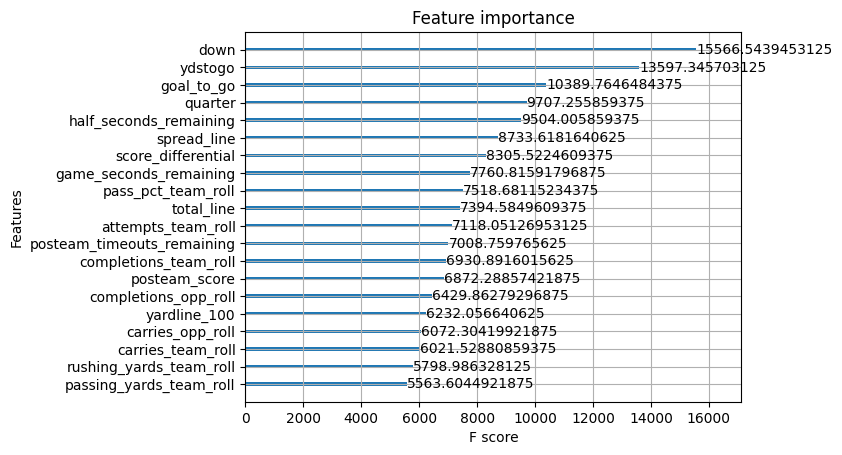

In [319]:
xgb.plot_importance(play_type_model,importance_type= 'cover', max_num_features=20)

In [320]:
joblib.dump(play_type_model, 'models/run_or_pass.joblib')

['models/run_or_pass.joblib']

In [321]:
{k:v for v,k in play_type_mapping.items()}

{0: 'field_goal',
 1: 'no_play',
 2: 'pass',
 3: 'punt',
 4: 'qb_kneel',
 5: 'qb_spike',
 6: 'run',
 7: 'pos_timeout',
 8: 'def_timeout',
 9: 'kickoff'}

In [322]:
feature_config = {
    'run_or_pass_cols':x_cols,
    'play_encoding': {k:v for v,k in play_type_mapping.items()}
}
update_config(feature_config)

In [323]:
r_data = small.loc[small.rush==1]
r_data
rx_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
r_data[context_cols + rx_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc,yardline_100,down,...,posteam_score,total_away_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,temp,spread_line,total_line
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19 yards (32-M.Williams; 36-C.Clark).,78.0,1.0,...,0.0,0.0,0.0,896.0,1796.0,3596.0,9.0,57.0,6.5,44.0
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to NYJ 46 for 5 yards (40-M.Harrison).,59.0,2.0,...,0.0,0.0,0.0,865.0,1765.0,3565.0,9.0,57.0,6.5,44.0
594882,254.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,"(12:41) (Shotgun) 8-L.Jackson right tackle to BAL 40 for 4 yards (57-C.Mosley, 3-J.Whitehead).",64.0,3.0,...,0.0,0.0,0.0,761.0,1661.0,3461.0,9.0,57.0,-6.5,44.0
594883,275.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:01) (Shotgun) 17-K.Drake right end to BAL 40 for no gain (56-Qu.Williams).,60.0,1.0,...,0.0,0.0,0.0,721.0,1621.0,3421.0,9.0,57.0,-6.5,44.0
594885,330.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,"(10:40) 17-K.Drake right tackle to BAL 49 for 1 yard (57-C.Mosley, 54-J.Martin).",52.0,3.0,...,0.0,0.0,0.0,640.0,1540.0,3340.0,9.0,57.0,-6.5,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728356,3609.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(7:56) (No Huddle) 28-J.Mixon up the middle to TEN 46 for 1 yard (69-S.Joseph).,47.0,1.0,...,27.0,30.0,-3.0,476.0,476.0,476.0,5.0,58.0,-8.0,40.5
728360,3707.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(6:17) 20-T.Pollard right end to TEN 2 for -4 yards (55-D.Hunter).,94.0,1.0,...,30.0,30.0,3.0,377.0,377.0,377.0,5.0,58.0,8.0,40.5
728370,3978.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(2:12) 28-J.Mixon left tackle to TEN 10 for no gain (98-J.Simmons).,10.0,2.0,...,27.0,30.0,-3.0,132.0,132.0,132.0,5.0,58.0,-8.0,40.5
728373,4051.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(1:53) 61-J.Ojukwu reported in as eligible. 20-T.Pollard left end to TEN 27 for 7 yards (45-D.White).,80.0,1.0,...,30.0,30.0,3.0,113.0,113.0,113.0,5.0,58.0,8.0,40.5
